# Setup

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.2 MB/s eta 0:00:00


In [ ]:
!pip install SciencePlots
!pip install latex
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7589 sha256=b4e23d783d93232b878428ec6d7bf4c3799e5001773893f4c3ce0e102481a052
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7228 sha256=392d516a049ca93703bf7e8d78d261a1ac6da92d2f0bde8b5f0965dfd5347b1b
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2766 sha256=9ad8d5114b151d350f39a35fabd454e6ddbeb4dfdd8caee801f4229935f3a91a
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e018891505911e82a6f358a0291e7681bae
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.w

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from gurobipy import Model, GRB, quicksum
import gurobipy as grb
import matplotlib.ticker as ticker
plt.style.use('science')

In [ ]:
options = {
    "WLSACCESSID": '',
    "WLSSECRET": '',
    "LICENSEID": ,
}

# Initializing the model
e = grb.Env("gurobi.log", params=options)
#e.setParam('OutputFlag', 0)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 786761
Set parameter LogFile to value "gurobi.log"
Academic license 786761 - for non-commercial use only - registered to sa___@mit.edu


#Objective value over different $d_i$ for $n=50$

In [ ]:
def run_sim(l,n,t,seed):
      np.random.seed(seed)
      # Generate random points
      points = np.random.uniform(0, l, size=(n,2))
      def euclidean_distance(point1, point2):
          return np.sqrt(np.sum((point1 - point2) ** 2))

      # Create a new model
      m = Model("k-median number of points", env=e)

      # Decision variables
      assign = {}
      for i in range(n):
          for j in range(n):
              assign[i, j] = m.addVar(vtype=GRB.BINARY, name=f"assign_{i}_{j}")

      centers = m.addVars(n, vtype=GRB.BINARY, name="centers")

      # Objective function: Minimize the sum of number of points
      m.setObjective(quicksum(centers[j] for j in range(n)), GRB.MINIMIZE)
      m.Params.LogToConsole = 0
      # Constraints
      # Each point must be assigned to one and only one center
      for i in range(n):
          m.addConstr(quicksum(assign[i, j] for j in range(n)) == 1)

      # If a point is assigned to a center, then that center must be selected
      for i in range(n):
          for j in range(n):
              m.addConstr(assign[i, j] <= centers[j])

      m.addConstr(quicksum(assign[i, j] * euclidean_distance(points[i], points[j])
                              for i in range(n) for j in range(n))<= t*n)
      # Optimize the model
      m.optimize()

      truesol = m.ObjVal

      P_i = n
      t_i = t

      B = 0.75 #UB Carlsson and Jones (2022) 0.38, LB 0.178, UB 0.75
      A_i = l**2
      ψ_i = 1

      lambda_i = P_i/A_i*(t_i/(B*ψ_i))**2
      Delta_i = lambda_i**2 / 4 + lambda_i**3 / 27
      alpha_i = 1 - np.cbrt(np.sqrt(Delta_i)+lambda_i/2) - np.cbrt(-np.sqrt(Delta_i)+lambda_i/2)

      ubsol = max(alpha_i*n,1)

      B = 0.178 #UB Carlsson and Jones (2022) 0.38, LB 0.178, UB 0.75
      A_i = l**2
      ψ_i = 1

      lambda_i = P_i/A_i*(t_i/(B*ψ_i))**2
      Delta_i = lambda_i**2 / 4 + lambda_i**3 / 27
      alpha_i = 1 - np.cbrt(np.sqrt(Delta_i)+lambda_i/2) - np.cbrt(-np.sqrt(Delta_i)+lambda_i/2)

      lbsol = max(alpha_i*n,1)


      B = 0.43222 # Carlsson and Jones (2022) 0.38, LB 0.178, UB 0.75
      A_i = l**2
      ψ_i = 1

      lambda_i = P_i/A_i*(t_i/(B*ψ_i))**2
      Delta_i = lambda_i**2 / 4 + lambda_i**3 / 27
      alpha_i = 1 - np.cbrt(np.sqrt(Delta_i)+lambda_i/2) - np.cbrt(-np.sqrt(Delta_i)+lambda_i/2)

      appsol = max(alpha_i*n,1)

      return truesol, ubsol, lbsol, appsol

In [ ]:
def Bfunc(alpha_i):
  return 0.171*alpha_i+0.3462

In [ ]:
l = 4
n = 50
t_space = np.linspace(0,l*0.5,21)
truesols = []
ubsols = []
lbsols = []
appsols = []
alpsols = []
alpsols2 = []
util = []
for t in t_space:
  truesolss = []
  ubsolss = []
  lbsolss = []
  appsolss = []
  for a in range(5):
      truesol, ubsol, lbsol, appsol = run_sim(l,n,t,a)
      truesolss.append(truesol)
      ubsolss.append(ubsol)
      lbsolss.append(lbsol)
      appsolss.append(appsol)
  print('t=',t)
  # print('true',np.average(truesolss))
  # print('ub',np.average(ubsolss))
  # print('lb',np.average(lbsolss))
  # print('app',np.average(appsolss))
  truesols.append(np.average(truesolss))
  ubsols.append(np.average(ubsolss))
  lbsols.append(np.average(lbsolss))
  appsols.append(np.average(appsolss))

t= 0.0
t= 0.1
t= 0.2
t= 0.30000000000000004
t= 0.4
t= 0.5
t= 0.6000000000000001
t= 0.7000000000000001
t= 0.8
t= 0.9
t= 1.0
t= 1.1
t= 1.2000000000000002
t= 1.3
t= 1.4000000000000001
t= 1.5
t= 1.6
t= 1.7000000000000002
t= 1.8
t= 1.9000000000000001
t= 2.0


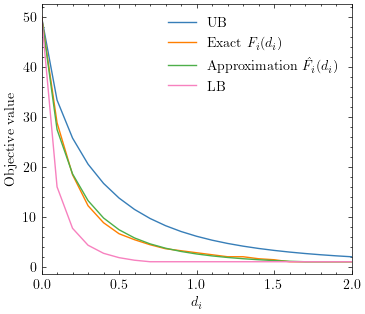

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.figure(figsize=(4, 3.5))
plt.plot(t_space, ubsols, color='#377eb8')
plt.plot(t_space, truesols, color='#ff7f00')
plt.plot(t_space, appsols, color='#4daf4a')
plt.plot(t_space, lbsols, color='#f781bf')
plt.xlim([0,l*0.5])
#plt.title('Objective value over different $d_i$ for $n=50$')
plt.xlabel('$d_i$')
plt.ylabel('Objective value')
plt.legend(['UB','Exact $F_i(d_i)$','Approximation $\hat{F}_i(d_i)$','LB'])
plt.show()

# Objective value over different n for $d_i=0.25$

In [ ]:
l = 4
t= 0.25
n_space = np.arange(10,101,10)
truesols1 = []
ubsols1 = []
lbsols1 = []
appsols1 = []
for n in n_space:
  print('n=',n)
  truesolss = []
  ubsolss = []
  lbsolss = []
  appsolss = []
  for a in range(5):
      truesol, ubsol, lbsol, appsol = run_sim(l,int(n),t,a+1)
      truesolss.append(truesol)
      ubsolss.append(ubsol)
      lbsolss.append(lbsol)
      appsolss.append(appsol)
  truesols1.append(np.average(truesolss))
  ubsols1.append(np.average(ubsolss))
  lbsols1.append(np.average(lbsolss))
  appsols1.append(np.average(appsolss))



n= 10
n= 20
n= 30
n= 40
n= 50
n= 60
n= 70
n= 80
n= 90
n= 100


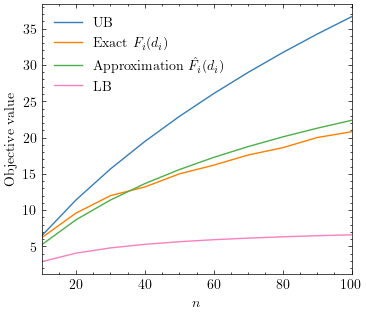

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.figure(figsize=(4, 3.5))
plt.plot(n_space, ubsols1, color='#377eb8')
plt.plot(n_space, truesols1, color='#ff7f00')
plt.plot(n_space, appsols1, color='#4daf4a')
plt.plot(n_space, lbsols1, color='#f781bf')
plt.xlim([10,n_space[-1]])
#plt.title('Objective value over different n for $d_i=0.25$')
plt.xlabel('$n$')
plt.ylabel('Objective value')
plt.legend(['UB','Exact $F_i(d_i)$','Approximation $\hat{F}_i(d_i)$','LB'])
plt.show()

# Run Time

In [ ]:
def run_time(l,n,t,seed):
      np.random.seed(seed)
      # Generate random points
      points = np.random.uniform(0, l, size=(n,2))
      # Function to calculate Manhattan distance (L1 norm) between two points
      def euclidean_distance(point1, point2):
          return np.sqrt(np.sum((point1 - point2) ** 2))

      # Create a new model
      m = Model("k-median number of points", env=e)

      # Decision variables
      assign = {}
      for i in range(n):
          for j in range(n):
              assign[i, j] = m.addVar(vtype=GRB.BINARY, name=f"assign_{i}_{j}")

      centers = m.addVars(n, vtype=GRB.BINARY, name="centers")

      # Objective function: Minimize the sum of number of points
      m.setObjective(quicksum(centers[j] for j in range(n)), GRB.MINIMIZE)
      #m.Params.LogToConsole = 0
      # Constraints
      # Each point must be assigned to one and only one center
      for i in range(n):
          m.addConstr(quicksum(assign[i, j] for j in range(n)) == 1)

      # If a point is assigned to a center, then that center must be selected
      for i in range(n):
          for j in range(n):
              m.addConstr(assign[i, j] <= centers[j])

      m.addConstr(quicksum(assign[i, j] * euclidean_distance(points[i], points[j])
                              for i in range(n) for j in range(n))<= t*n)
      # Optimize the model
      m.optimize()

      return m.Runtime

In [ ]:
l = 4
t= 0.25
n_space = list(np.arange(10,101,10)) + [200,250,300,350,400]
runs_time = []
for n in n_space:
  print('n=',n)
  run_times = []
  if n < 200:
    for a in range(5):
        runtime = run_time(l,int(n),t,a) # Call the function 'run_time'
        run_times.append(runtime) # Append to the list 'run_times'
    runs_time.append(np.average(run_times)) # Append to the list 'runs_time'
  else:
    runs_time.append(run_time(l,int(n),t,a))

n= 10
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 786761 - for non-commercial use only - registered to sa___@mit.edu
Optimize a model with 111 rows, 110 columns and 390 nonzeros
Model fingerprint: 0x6573b74e
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 8.0000000
Presolve removed 61 rows and 44 columns
Presolve time: 0.00s
Presolved: 50 rows, 66 columns, 217 nonzeros
Variable types: 0 continuous, 66 integer (66 binary)

Root relaxation: objective 6.227050e+00, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

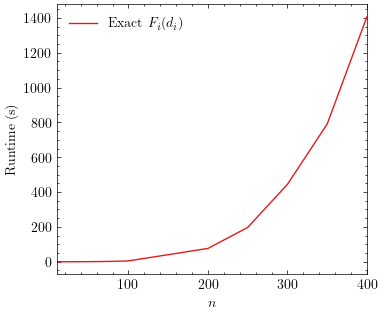

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.figure(figsize=(4, 3.5))
plt.plot(n_space, runs_time, color='#e41a1c')
plt.xlim([10,n_space[-1]])
#plt.title('Objective value over different n for $d_i=0.25$')
plt.xlabel('$n$')
plt.ylabel('Runtime (s)')
plt.legend(['Exact $F_i(d_i)$'])
plt.show()

In [ ]:
l = 4
t= 0.25
n_space500 = [500]
runs_time500 = []
for n in n_space500:
  print('n=',n)
  run_times = []
  for a in range(1):
      runtime = run_time(l,int(n),t,a) # Call the function 'run_time'
      run_times.append(runtime) # Append to the list 'run_times'
  runs_time500.append(np.average(run_times)) # Append to the list 'runs_time'

n= 500
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 786761 - for non-commercial use only - registered to sa___@mit.edu
Optimize a model with 250501 rows, 250500 columns and 999500 nonzeros
Model fingerprint: 0xde7c50b5
Variable types: 0 continuous, 250500 integer (250500 binary)
Coefficient statistics:
  Matrix range     [7e-03, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 439.0000000
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve time: 10.49s
Presolved: 250501 rows, 250500 columns, 999500 nonzeros
Variable types: 0 continuous, 250500 integer (250500 binary)

Root simplex log...

Iteration    Obje

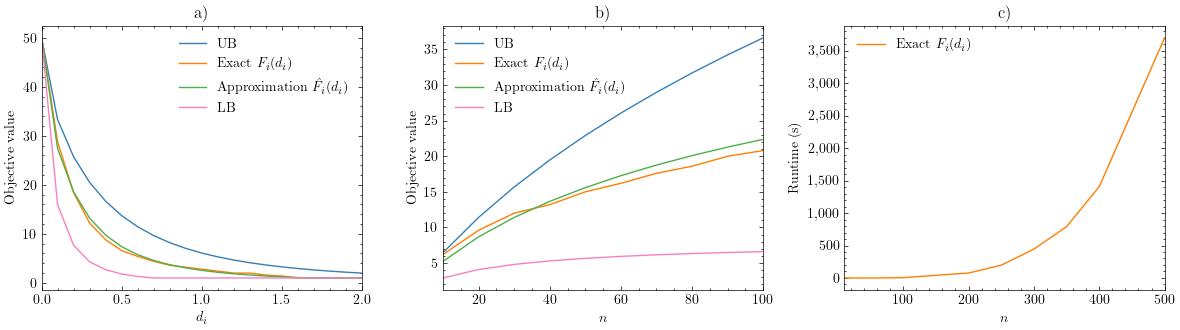

In [ ]:
# Define a formatter function
def yaxis_format(x, pos):
    return f'{x:,.0f}'

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# First plot
axs[0].plot(t_space, ubsols, color='#377eb8')
axs[0].plot(t_space, truesols, color='#ff7f00')
axs[0].plot(t_space, appsols, color='#4daf4a')
axs[0].plot(t_space, lbsols, color='#f781bf')
axs[0].set_xlim([0, l * 0.5])
axs[0].set_xlabel('$d_i$')
axs[0].set_ylabel('Objective value')
axs[0].legend(['UB', 'Exact $F_i(d_i)$', 'Approximation $\hat{F}_i(d_i)$', 'LB'])
axs[0].set_title('a)')

# Second plot
axs[1].plot(n_space[:10], ubsols1, color='#377eb8')
axs[1].plot(n_space[:10], truesols1, color='#ff7f00')
axs[1].plot(n_space[:10], appsols1, color='#4daf4a')
axs[1].plot(n_space[:10], lbsols1, color='#f781bf')
axs[1].set_xlim([10, 100])
axs[1].set_xlabel('$n$')
axs[1].set_ylabel('Objective value')
axs[1].legend(['UB', 'Exact $F_i(d_i)$', 'Approximation $\hat{F}_i(d_i)$', 'LB'])
axs[1].set_title('b)')

# Third plot
axs[2].plot(list(n_space)+n_space500, runs_time+runs_time500, color='#ff7f00')
axs[2].set_xlim([10, 500])
axs[2].set_xlabel('$n$')
axs[2].set_ylabel('Runtime (s)')
axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(yaxis_format))
axs[2].legend(['Exact $F_i(d_i)$'])
axs[2].set_title('c)')

# Adjust layout
plt.tight_layout()

plt.savefig("numerical_study.pdf")
plt.show()